In [3]:
import cv2
import numpy as np

def count_red_pixels(image):
    # Convert the image to BGR color space
    image_bgr = cv2.cvtColor(image, cv2.COLOR_GRAY2BGR)

    # Define the lower and upper bounds for red color in BGR format
    lower_red = np.array([0, 0, 100])
    upper_red = np.array([50, 50, 255])

    # Threshold the image to get a binary mask of red pixels
    mask = cv2.inRange(image_bgr, lower_red, upper_red)

    # Count the number of white pixels in the mask
    count = cv2.countNonZero(mask)

    return count


In [4]:
def print_pixel_over_ROI(x,y,w,h,image_gray):
    
    # Iterate over each pixel in the image
    for row in range(y,y+h):
        for col in range(x,x+w):
            # Access the pixel value at the current position
            pixel = image_gray[row, col]

            # Print the pixel value
            print('Pixel at ({}, {}): {}'.format(row, col, pixel))
        

In [5]:
def crop_image(x,y,w,h,image_gray):
    return image_gray[y:y+h, x:x+w]

In [2]:
#apply threshold, then aspect ratio

import cv2
import numpy as np
import os

def extract_middle_roi(image, target_width):
    # Get the original image dimensions
    height, width = image.shape[:2]

    # Calculate the aspect ratio
    aspect_ratio = width / height

    # Calculate the target height based on the aspect ratio
    target_height = int(target_width / aspect_ratio)

    # Calculate the coordinates of the top-left and bottom-right corners of the middle region
    x = int((width - target_width) / 2)
    y = int((height - target_height) / 2)
    x2 = x + target_width
    y2 = y + target_height

    # Extract the middle region
    middle_roi = image[y:y2, x:x2]

    return middle_roi

# Iterate over the contours and filter out ovals with a width-to-length ratio:

def filter_contours(contours, binary_image, ratio): #defaults to red
    
    #ratio is a list with first element as lower bound and second element as upper bound
    filtered_contours = []
    for contour in contours:
        x, y, w, h = cv2.boundingRect(contour)
        aspect_ratio = float(w)/h
        if aspect_ratio >= ratio[0] and aspect_ratio<=ratio[1]:
            filtered_contours.append(contour)

    # Create a mask of the filtered contours
    mask = np.zeros_like(binary_image)
    cv2.drawContours(mask, filtered_contours, -1, (255), thickness=cv2.FILLED)
    return mask
    
def preprocess_image(image_path, threshold_val = 0):
    # Load the grayscale image
    image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    
    #crop image
    image = extract_middle_roi(image, 1500)
    
    if threshold_val == 0:
        
#         find threshold with sd
        for x in range(5, 20):
        
            mask = np.where(image < x, 1, 0)
            masked_intensities = image[mask == 1]

            mean_intensity = np.mean(masked_intensities)
            sd_intensity = np.std(masked_intensities)
            two_sd = (mean_intensity + (2 * sd_intensity))
            three_sd = (mean_intensity + (3 * sd_intensity))
            print("current threshold: {}".format(x))
            print("two_sd: {}".format(two_sd))
            print("three_sd: {}".format(three_sd))
            
            if x>=two_sd and x<=three_sd:
                threshold_val = x
                
        _, binary_image = cv2.threshold(image, threshold_val, 255, cv2.THRESH_BINARY)
        
#         # Get the threshold value
        threshold_val = _

        # Apply the thresholding using standard deviations
#         binary_image = threshold_by_std_dev(image, 1.5)
        
    else:
    # apply threshold
        _, binary_image = cv2.threshold(image, threshold_val, 255, cv2.THRESH_BINARY)
    print("Threshold value:", threshold_val)
    
    #Save and download to local disk
    # Extract the filename from the original image path
    filename = image_path.split("/")[-1]

    # Create the new path by concatenating the desired directory and the filename
    new_path = os.path.dirname(image_path) + "/thresholded/"

    # Create the folder if it doesn't exist
    if not os.path.exists(new_path):
        os.makedirs(new_path)

    new_path+=filename

    cv2.imwrite(new_path, binary_image)
    
    print("Saved thresholded image to: {}".format(new_path))

    #find contours in the image
    contours, _ = cv2.findContours(binary_image, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    # Iterate over the contours and filter out ovals with a width-to-length ratio:
    red_ratio = [2, 10]
    blue_ratio = [1, 2]
    green_ratio = [0,1]
    ratio_map = {"red":red_ratio, "blue":blue_ratio, "green":green_ratio}
    
    for color_name, color_ratio in ratio_map.items():
        mask = filter_contours(contours, binary_image, color_ratio)

        #apply the mask
        binary_image = cv2.bitwise_and(binary_image, binary_image, mask=mask)

        #Save and download to local disk
        # Extract the filename from the original image path
        filename = image_path.split("/")[-1]

        # Create the new path by concatenating the desired directory and the filename
        new_path = os.path.dirname(image_path) + "/" + color_name + "/"

        # Create the folder if it doesn't exist
        if not os.path.exists(new_path):
            os.makedirs(new_path)

        new_path+=filename

        cv2.imwrite(new_path, binary_image)
    
    return threshold_val

image_path = "/mnt/c/Users/alada/JC_Code/JC-SDKIntegration/patterns/32_32_32_clear.bmp"
# image_path = "/mnt/c/Users/alada/JC_Code/JC-SDKIntegration/RGB_Grayscale_Images/32_0_32.bmp"
# print(preprocess_image(image_path, threshold_val=11))

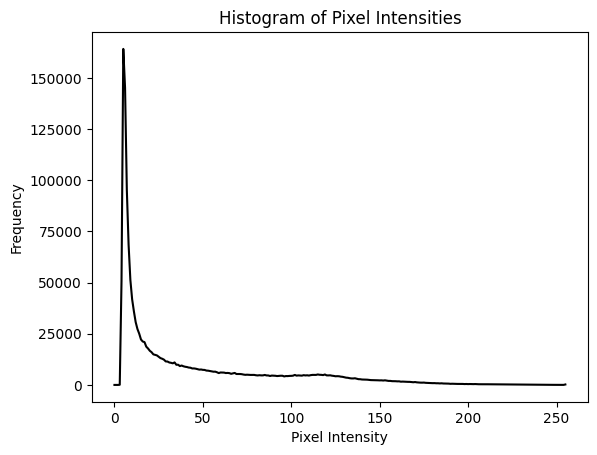

In [8]:
import cv2
import matplotlib.pyplot as plt

def extract_middle_roi(image, target_width):
    # Get the original image dimensions
    height, width = image.shape[:2]

    # Calculate the aspect ratio
    aspect_ratio = width / height

    # Calculate the target height based on the aspect ratio
    target_height = int(target_width / aspect_ratio)

    # Calculate the coordinates of the top-left and bottom-right corners of the middle region
    x = int((width - target_width) / 2)
    y = int((height - target_height) / 2)
    x2 = x + target_width
    y2 = y + target_height

    # Extract the middle region
    middle_roi = image[y:y2, x:x2]

    return middle_roi

# Read image in grayscale
image_path = "/mnt/c/Users/alada/JC_Code/JC-SDKIntegration/Red32/32_32_32_clear_4000.bmp"
image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
image = extract_middle_roi(image, 1500)
# Calculate histogram
histogram = cv2.calcHist([image], [0], None, [256], [0, 256])


# Convert histogram to numpy array
hist_array = np.array(histogram)

# Print the results
# Plot histogram
plt.plot(histogram, color='black')
plt.xlabel('Pixel Intensity')
plt.ylabel('Frequency')
plt.title('Histogram of Pixel Intensities')
plt.show()

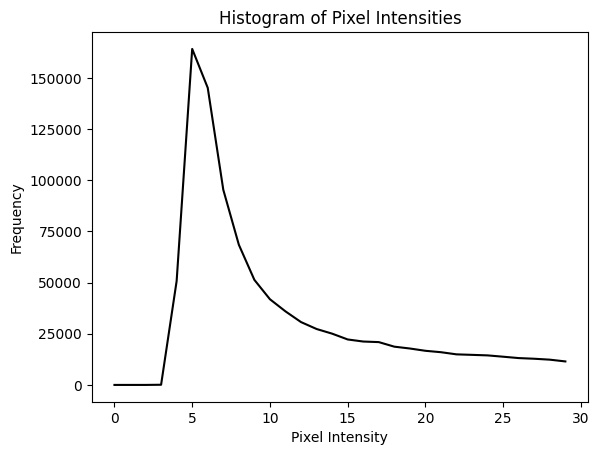

In [3]:
import cv2
import matplotlib.pyplot as plt

def extract_middle_roi(image, target_width):
    # Get the original image dimensions
    height, width = image.shape[:2]

    # Calculate the aspect ratio
    aspect_ratio = width / height

    # Calculate the target height based on the aspect ratio
    target_height = int(target_width / aspect_ratio)

    # Calculate the coordinates of the top-left and bottom-right corners of the middle region
    x = int((width - target_width) / 2)
    y = int((height - target_height) / 2)
    x2 = x + target_width
    y2 = y + target_height

    # Extract the middle region
    middle_roi = image[y:y2, x:x2]

    return middle_roi

# Read image in grayscale
image_path = "/mnt/c/Users/alada/JC_Code/JC-SDKIntegration/Red32/32_32_32_clear_4000.bmp"
image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
image = extract_middle_roi(image, 1500)
# Calculate histogram
histogram = cv2.calcHist([image], [0], None, [30], [0, 30])


# Convert histogram to numpy array
hist_array = np.array(histogram)

# Print the results
# Plot histogram
plt.plot(histogram, color='black')
plt.xlabel('Pixel Intensity')
plt.ylabel('Frequency')
plt.title('Histogram of Pixel Intensities')
plt.show()

In [3]:
# try different threshold, and save these images
import cv2 
import numpy as np
import csv

# Read image in grayscale
image_path = "/mnt/c/Users/alada/JC_Code/JC-SDKIntegration/Red32/32_32_32_clear_4000.bmp"
image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
image = extract_middle_roi(image, 1500)

# Initialize a list to store the results
results = []

for threshold in range(5, 50):
    _, filtered_image = cv2.threshold(image, threshold, 255, cv2.THRESH_BINARY)
    new_path = "/mnt/c/Users/alada/JC_Code/JC-SDKIntegration/ThresholdExperiment/threshold=" + str(threshold) + ".bmp"
#     cv2.imwrite(new_path, filtered_image)
    
    # for each image, find the average, sd, and average + sd, and export them to a csv file
    
    # Perform calculations for black pixels
    black_mask = np.where(image < threshold, 1, 0)
    black_masked_intensities = image[black_mask == 1]
    black_mean_intensity = np.mean(black_masked_intensities)
    black_sd_intensity = np.std(black_masked_intensities)
    black_one_sd = black_mean_intensity + (1 * black_sd_intensity)
    black_two_sd = black_mean_intensity + (2 * black_sd_intensity)
    
    # Perform calculations for white pixels
    white_mask = np.where(image >= threshold, 1, 0)
    white_masked_intensities = image[white_mask == 1]
    white_mean_intensity = np.mean(white_masked_intensities)
    white_sd_intensity = np.std(white_masked_intensities)
    white_one_sd = white_mean_intensity + (1 * white_sd_intensity)
    white_two_sd = white_mean_intensity + (2 * white_sd_intensity)
    
    # Store the results in a dictionary
    result = {
        'Threshold': threshold,
        'Mean Intensity of Black Pixels': black_mean_intensity,
        'Standard Deviation of Black Pixels': black_sd_intensity,
        'Black One SD Above Average': black_one_sd,
        'Black Two SD Above Average': black_two_sd,
        'Mean Intensity of White Pixels': white_mean_intensity,
        'Standard Deviation of White Pixels': white_sd_intensity,
        'White One SD Above Average': white_one_sd,
        'White Two SD Above Average': white_two_sd
    }
    results.append(result)
    
# Define the CSV file path
csv_file_path = '/mnt/c/Users/alada/JC_Code/JC-SDKIntegration/ThresholdExperiment/results.csv'

# Define the fieldnames for the CSV file
fieldnames = [
    'Threshold',
    'Mean Intensity of Black Pixels',
    'Standard Deviation of Black Pixels',
    'Black One SD Above Average',
    'Black Two SD Above Average',
    'Mean Intensity of White Pixels',
    'Standard Deviation of White Pixels',
    'White One SD Above Average',
    'White Two SD Above Average'
]

# Write the results to the CSV file
with open(csv_file_path, 'w', newline='') as csvfile:
    writer = csv.DictWriter(csvfile, fieldnames=fieldnames)
    writer.writeheader()

    for result in results:
        writer.writerow(result)


# Print a confirmation message
print("Results exported to results.csv")

Results exported to results.csv


In [35]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

def get_max_intensity_location(image_name):
    # Load the grayscale image
    image = cv2.imread(image_name, cv2.IMREAD_GRAYSCALE)

    # Initialize variables to track the highest intensity and its location
    max_intensity = 0
    max_intensity_location = None

    # Iterate over each pixel in the image
    for x in range(image.shape[0]):
        for y in range(image.shape[1]):
            intensity = image[x,y]

            # Update the highest intensity and its location if a higher intensity is found
            if intensity > max_intensity and intensity < 255:
                max_intensity = intensity
                max_intensity_location = (x,y)
    
    # Print the highest intensity pixel
    print("Highest intensity:", max_intensity)
    
    # Print the location of the highest intensity pixel
    print("Highest intensity location:", max_intensity_location)
    return max_intensity_location

def plot_intensity_vs_x(image_name, y):
    
    # Load the grayscale image
    image = cv2.imread(image_name, cv2.IMREAD_GRAYSCALE)

    # Initialize lists to store the x-axis coordinates and y-axis intensities
    x_coordinates = []
    y_intensities = []

    # Iterate over each pixel in the image
    for x in range(image.shape[0]):
        intensity = image[x, y]
        x_coordinates.append(x)
        y_intensities.append(intensity)

    # Plot the graph
    plt.plot(x_coordinates, y_intensities)
    plt.xlabel('X Coordinates')
    plt.ylabel('Pixel Intensity')
    plt.title('Intensity vs X Coordinate')

    plt.savefig(image_name + "_vs_x.jpg")
    
    plt.show()
    
def plot_intensity_vs_y(image_name, x):
    
    # Load the grayscale image
    image = cv2.imread(image_name, cv2.IMREAD_GRAYSCALE)

    # Initialize lists to store the x-axis coordinates and y-axis intensities
    y_coordinates = []
    intensities = []

    # Iterate over each pixel in the image
    for y in range(image.shape[1]):
        intensity = image[x, y]
        y_coordinates.append(y)
        intensities.append(intensity)
        
    # Plot the graph
    plt.plot(y_coordinates, intensities)
    plt.xlabel('Y Coordinates')
    plt.ylabel('Pixel Intensity')
    plt.title('Intensity vs Y Coordinate')
    
    plt.savefig(image_name + "_vs_y.jpg")
    plt.show()
    

In [21]:
print(image[381,4242])

255
10640


Highest intensity: 244
Highest intensity location: (5995, 7892)


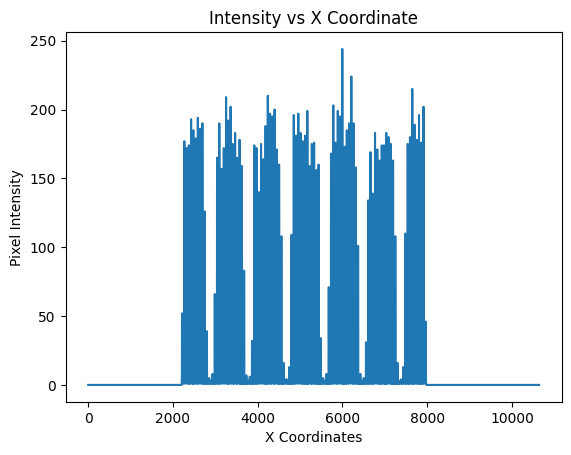

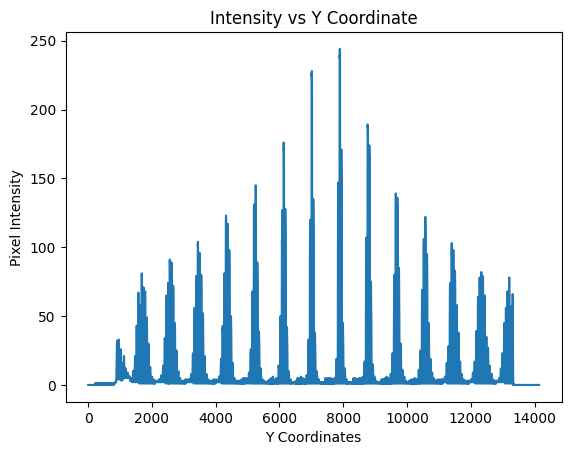

Highest intensity: 254
Highest intensity location: (3176, 6483)


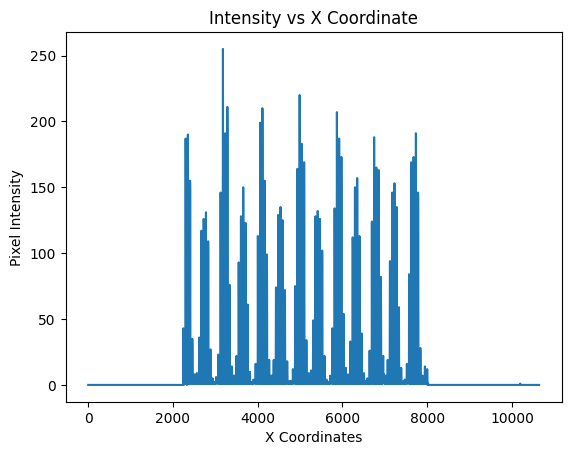

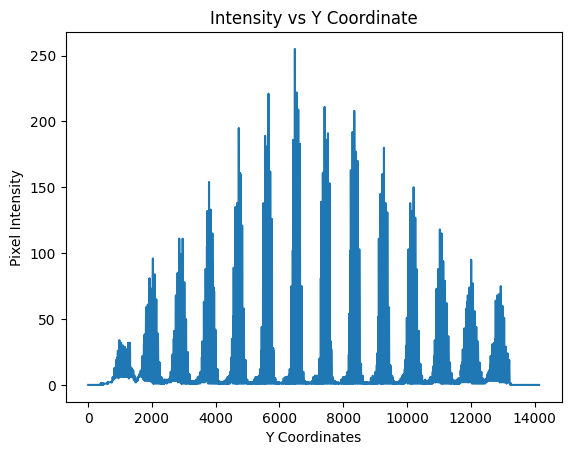

Highest intensity: 254
Highest intensity location: (2966, 8862)


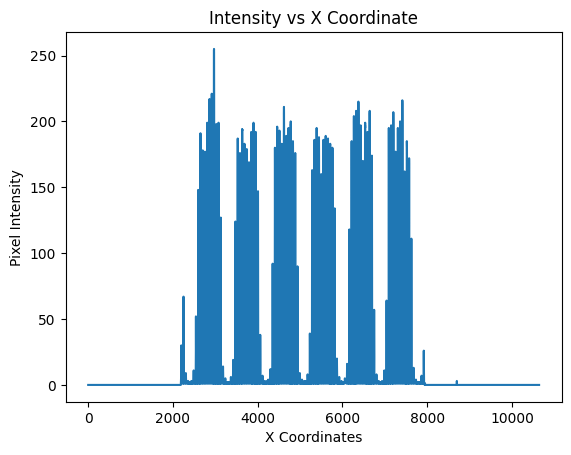

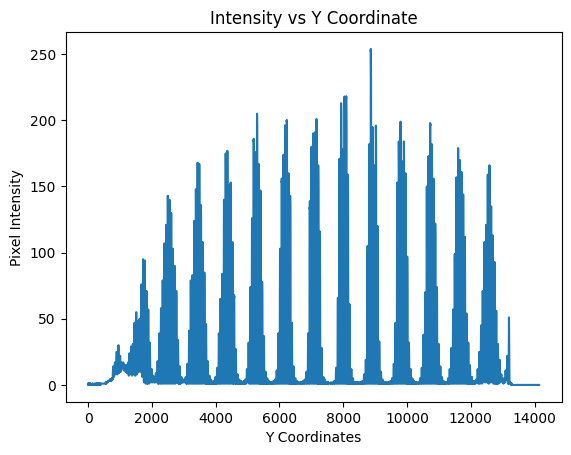

In [36]:
red_image = '32_32_32_X_4000000.bmp'
green_image = '32_32_32_Y_3500000.bmp'
blue_image = '32_32_32_Z_6200000.bmp'

images = [red_image,green_image,blue_image]

for image in images:
    x, y = get_max_intensity_location(image)
    plot_intensity_vs_x(image, y)
    plot_intensity_vs_y(image,x)

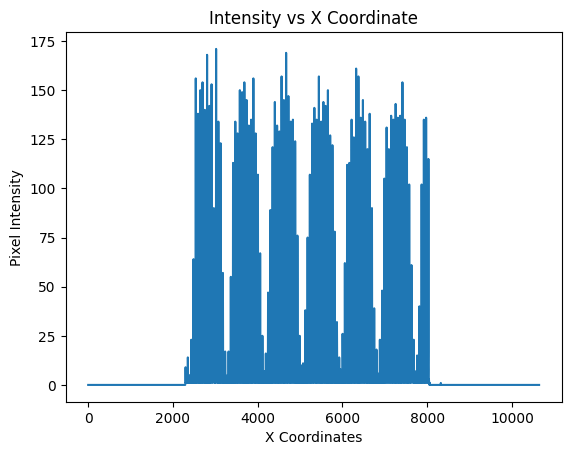

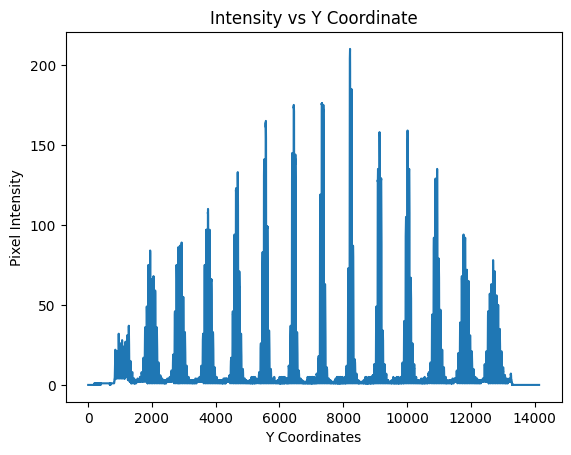

In [34]:
plot_intensity_vs_x(red_image, 5000)
plot_intensity_vs_y(red_image,5000)